In [92]:
from pymongo import MongoClient
from pprint import pprint
import igraph
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sys
import pymongo
import gensim
import re
from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from dateutil.relativedelta import relativedelta
import datetime
from pyLDAvis import sklearn
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


try:
    client = MongoClient('localhost', 27017) # host, port
except ConnectionFailure as e:
    sys.stderr.write("Could not connect to MongoDB: %s" % e)
    sys.exit(1)

In [4]:
# get database with all tweets
db = client.tweets_database

#client.tweets_database.filtered_tweets_noRetweets_english.drop()
db.users_manual_label.rename("users_manual_label_OLD")

en_noRetweets_noInstitutions = client.tweets_database.en_noRetweets_noInstitutions

client.tweets_database.collection_names()

['users_manual_label_OLD',
 'raw_tweets',
 'users_manual_label_all_tweets',
 'en_noRetweets_noInstitutions',
 'english_tweets',
 'english_noRetweet_tweets',
 'users',
 'tweets_manual_label']

In [5]:
import sys
path = 'D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\preprocess'

if path not in sys.path:
    sys.path.insert(0, path)
sys.path

from preprocess import Preprocess
prep = Preprocess()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stagiaire2014\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Concatenate all tweets of one person in one month to one single document

In [6]:
users = en_noRetweets_noInstitutions.find().distinct("user.screen_name")

In [12]:
en_noRetweets_noInstitutions.create_index("user.screen_name")

'user.screen_name_1'

In [13]:
print("Number of distinct users:", len(users))
print("Number of tweets:", en_noRetweets_noInstitutions.count())

count_single_tweets = 0
for user in users:
    user_tweets = en_noRetweets_noInstitutions.find({'user.screen_name' : user})
    if user_tweets.count() == 1:
        count_single_tweets += 1
        
print("Number of users that tweet only once:", count_single_tweets)

Number of distinct users: 232408
Number of tweets: 399148
Number of users that tweet only once: 181141


In [70]:
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_special_words(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete",
                                           mode_Hashtag="replace")
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)

    tweet = prep.preprocess_emojis(tweet)
    tweet = prep.preprocess_emoticons(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.to_lowercase(tweet)

    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = prep.lemmatize_verbs(tweet)
    tweet = prep.stem_words(tweet)
    #tweet = [ x for x in tweet if x not in[""] ]
#    tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
#                                          "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
#                                          "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
#                                          "ii", "dr", "rt", "bc", "ok", "think", "make"] ]

    return tweet

### Concatenate tweets of same months

In [90]:
def to_date(twitter_date):
    return datetime.datetime.strptime(twitter_date, '%a %b %d %H:%M:%S +0000 %Y')

tweet_docs = []
for j, user in enumerate(users):
    user_tweets = en_noRetweets_noInstitutions.find({'user.screen_name' : user})
    nTweets = user_tweets.count()
    
    if nTweets > 100:
        print("\tnTweets:", nTweets)
    
    if nTweets == 1:
        tweet = user_tweets.next()
        tweet_docs.append(preprocess_tweet(tweet["text"]))
        
    else:
        user_tweets = user_tweets.sort('date', pymongo.ASCENDING)
        start_date = user_tweets[0]['created_at']
        end_date = to_date(start_date) + relativedelta(months=1)
        #print("\tstart_date:", start_date)
        #print("\tend_date:", end_date)
        #print("\t Text:", user_tweets[0]["text"])
        #print()
        
        tweet_doc = user_tweets[0]["text"] # concatenation of tweets of a user of the same months
        nt = 1
        
        while nt < nTweets:
            
            current_tweet = user_tweets[nt]
            #print("\tcurrent_date:", current_tweet["created_at"])
            #print("\t Text:", user_tweets[nt]["text"])

            if to_date(current_tweet["created_at"]) < end_date:
                tweet_doc += " "+current_tweet["text"]
            else:
                #print("\t APPEND:")
                #print("\t", tweet_doc)
                tweet_docs.append(preprocess_tweet(tweet_doc))
                tweet_doc = current_tweet["text"]
                end_date = to_date(current_tweet["created_at"]) + relativedelta(months=1)
                #print("\t new enddate:", end_date)
            #print()
            
            nt += 1
        #print("\t APPEND:")
        #print("\t", tweet_doc)
        tweet_docs.append(tweet_doc)

    if j %10000 == 0:
        print(j)

len(tweet_docs)

In [91]:
tweet_docs_preproc = []
for tweet in tweet_docs:
    tweet_docs_preproc.append(preprocess_tweet(tweet))


tweet_docs_preproc[0]

In [72]:
# assigning a unique integer id to each unique token while also collecting word counts and relevant statistics.
dictionary = Dictionary(tweet_docs_preproc)
len(dictionary)

87321

In [73]:
# converts dictionary into bag of words: list of vectors (term ID, term frequency)
corpus = [dictionary.doc2bow(text) for text in tweet_docs_preproc]
len(corpus)

271722

In [74]:
NUM_TOPICS = 8
 
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, distributed=False,
                           chunksize=5000, passes=50, eval_every=None, alpha='auto', eta='auto',
                           iterations=50) # eval_every estimates log perplexity every that many updates, but slows down


c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [75]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 

LDA Model:
Topic #0: 0.283*"insulin" + 0.029*"use" + 0.022*"pump" + 0.017*"need" + 0.017*"new" + 0.016*"shoot" + 0.013*"inject" + 0.012*"break" + 0.011*"needl" + 0.011*"forget"
Topic #1: 0.051*"fuck" + 0.037*"heart" + 0.034*"fat" + 0.033*"cancer" + 0.028*"diseas" + 0.021*"ass" + 0.018*"ur" + 0.018*"cure" + 0.018*"obes" + 0.015*"wanna"
Topic #2: 0.175*"diabet" + 0.040*"get" + 0.020*"like" + 0.019*"go" + 0.013*"give" + 0.012*"eat" + 0.010*"one" + 0.010*"would" + 0.010*"think" + 0.009*"make"
Topic #3: 0.169*"glucos" + 0.084*"sugar" + 0.072*"guardian" + 0.039*"test" + 0.035*"blood" + 0.020*"high" + 0.014*"diet" + 0.012*"level" + 0.010*"bodi" + 0.010*"check"
Topic #4: 0.051*"day" + 0.044*"year" + 0.039*"time" + 0.035*"two" + 0.034*"today" + 0.023*"three" + 0.020*"old" + 0.020*"diagnos" + 0.019*"everi" + 0.017*"last"
Topic #5: 0.121*"TYPEONE" + 0.045*"help" + 0.034*"pleas" + 0.022*"world" + 0.017*"son" + 0.014*"daughter" + 0.013*"hi" + 0.011*"thank" + 0.011*"halloween" + 0.011*"worlddiabetes

In [76]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [77]:
pyLDAvis.display(vis)

In [111]:
pyLDAvis.save_html(vis, "topics_vis/topics_K_8.html")

In [108]:
# FIND THE DOMINANT TOPIC IN EACH SENTENCE

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tweet_docs):
    # Init output
    sent_topics_df = pd.DataFrame()#

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
                
        if i % 1000 == 0: 
            print(i)
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tweet_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
#df_dominant_topic.head(10)

In [83]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4449,"diabet, get, like, go, give, eat, one, would, ...",So im an idiot. I bought a sandwich but for la...
1,1,2.0,0.5641,"diabet, get, like, go, give, eat, one, would, ...","From my head to my diabetic feet, yah!!!! http..."
2,2,2.0,0.6742,"diabet, get, like, go, give, eat, one, would, ...",Oh yeah..and a side of diabetes https://t.co/P...
3,3,2.0,0.5278,"diabet, get, like, go, give, eat, one, would, ...",So happy I can eat pizza &amp; candy anytime I...
4,4,2.0,0.3399,"diabet, get, like, go, give, eat, one, would, ...","Hung out with my fave DiaBoy yesterday, @Jedia..."
5,5,2.0,0.2874,"diabet, get, like, go, give, eat, one, would, ...","At dx in 1996, my life in insulin cost $42,000..."
6,6,2.0,0.3054,"diabet, get, like, go, give, eat, one, would, ...",We interrupt this insulin pricing coverage for...
7,7,7.0,0.2990,"pay, w, afford, without, medic, med, insur, pa...",@FDALawyers @DavidP4AD None. Because it's insu...
8,8,7.0,0.3233,"pay, w, afford, without, medic, med, insur, pa...",@matthewherper @PhRMA cites YOU in its Nevada ...
9,9,2.0,0.3021,"diabet, get, like, go, give, eat, one, would, ...",This is fantastic - shows the history of how i...


In [85]:
# FIND THE MOST REPRESENTATIVE DOCUMENT FOR EACH TOPIC 

# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                      axis=0)
    
    
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5885,"insulin, use, pump, need, new, shoot, inject, ...",Diabeitc insulin pen needle\n@Diabetesanddiet ...
1,1.0,0.7424,"fuck, heart, fat, cancer, diseas, ass, ur, cur...",We have tried Immunotec - and it can help you ...
2,2.0,0.9078,"diabet, get, like, go, give, eat, one, would, ...",🗣🗣🗣🗣🗣🗣🗣🗣🗣\nWhy hasn't Santa died from diabetes...
3,3.0,0.7644,"glucos, sugar, guardian, test, blood, high, di...",My mather's cholesterl level is low.My mather'...
4,4.0,0.5586,"day, year, time, two, today, three, old, diagn...",happy birthday diabetes @Appointedgnome x x x ...
5,5.0,0.5620,"TYPEONE, help, pleas, world, son, daughter, hi...",Help me create a world without type 1 diabetes...
6,6.0,0.4738,"EMOT_LAUGH, famili, run, may, finger, leg, pri...",Brain on fire!🔥🔥\n#chloegracemoretz #chloegmor...
7,7.0,0.6345,"pay, w, afford, without, medic, med, insur, pa...",Medication Price Gouging example: Pre-Ocare 10...


In [106]:
for t in sent_topics_sorteddf["Text"]:
    pprint(t)
    print()

## Grid search to find best number of classes

In [98]:

def evaluate_graph(dictionary, corpus, texts, list_num_topics):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    logPerplex_list = []
    for num_topics in list_num_topics:
        print("number of topics:", num_topics)
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=0,
                      chunksize=5000, passes=50, eval_every=None, alpha='auto', eta='auto', iterations=50)
        
        
        lm_list.append(lm)
        logPerplex_list.append(lm.log_perplexity(corpus))
        cm = CoherenceModel(model=lm, corpus=corpus, dictionary=dictionary, texts=texts, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    #x = list_num_topics #range(1, limit)
    #plt.plot(x, c_v)
    #plt.xlabel("num_topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("c_v"), loc='best')
    #plt.show()
    
    return lm_list, c_v, logPerplex_list


                           


list_num_topics = [6, 8, 10, 12, 15]
lmlist, c_v, logPerplex_list = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=tweet_docs_preproc, list_num_topics=list_num_topics)

number of topics: 6
number of topics: 8
number of topics: 10
number of topics: 12
number of topics: 15


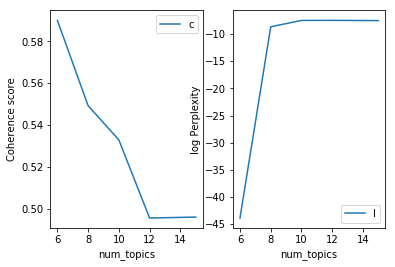

In [99]:
plt.figure()

plt.subplot(121)
plt.plot(list_num_topics, c_v)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')

plt.subplot(122)
plt.plot(list_num_topics, logPerplex_list)
plt.xlabel("num_topics")
plt.ylabel("log Perplexity")
plt.legend(("logPerpl"), loc='best')

plt.show()

In [101]:
vis = pyLDAvis.gensim.prepare(lmlist[np.argmax(c_v)], corpus, dictionary, n_jobs=1)
pyLDAvis.display(vis)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [110]:
pyLDAvis.save_html(vis, "topics_vis/topics_K_6.html")

In [15]:

    
class CustomVectorizer(CountVectorizer):
    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
        def build_analyzer(self):
            # load stop words using CountVectorizer's built in method
            stop_words = self.get_stop_words()
            
            # create the analyzer that will be returned by this method
            def analyser(tweet):
                #print("tweet")
                #print(tweet)

                tweet = prep.replace_contractions(tweet)
                tweet = prep.replace_hashtags_URL_USER(tweet, mode="delete")
                tweet = prep.tokenize(tweet)
                tweet = prep.remove_punctuation(tweet)

                tweet = prep.preprocess_emojis(tweet)
                tweet = prep.preprocess_emoticons(tweet)
                tweet = prep.remove_non_ascii(tweet)
                tweet = prep.replace_numbers(tweet, mode="delete")
                tweet = prep.to_lowercase(tweet)

                tweet = prep.remove_stopwords(tweet)
                tweet = prep.lemmatize_verbs(tweet)
                tweet = prep.stem_words(tweet)
                tweet = [ x for x in tweet if x not in["diabet", "glucos", "insulin", "type", "1", "2", "", "get", "sugar", "would",
                                                      "go", "know", "take", "give", "say", "one", "could", "would", "people", "look",
                                                      "year", "test", "see", "oh", "via", "bitch", "daddi", "hi", "w", "b", "n", "c",
                                                      "ii", "dr", "rt", "bc", "ok", "think", "make"] ]


                return tweet
            
            return(analyser)

In [16]:
#stopwords = ["USER", "", "type", "diabet", "1", "2", "insulin", "glucos"]
vectorizer_test = CustomVectorizer(min_df=5, max_df=0.9, lowercase=True, analyzer = 'word' )
                            # stop_words=stopwords, lowercase=True, analyzer = 'word' )

In [23]:
tweets_preprocessed = vectorizer_test.fit_transform(tweets_list)

In [29]:
a = vectorizer_test.inverse_transform(tweets_preprocessed[0])
print(tweets_preprocessed[0])
print(a)
type(tweets_preprocessed)

  (0, 5893)	1
  (0, 5142)	1
  (0, 1722)	1
  (0, 142)	1
  (0, 9004)	1
  (0, 13568)	1
  (0, 2727)	1
  (0, 7795)	1
  (0, 7850)	1
[array(['ffs', 'eat', 'automat', '11am', 'later', 'sandwich', 'buy',
       'idiot', 'im'], dtype='<U46')]


scipy.sparse.csr.csr_matrix

In [19]:
%env JOBLIB_TEMP_FOLDER="D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\jupyter_notebooks\tmp"

env: JOBLIB_TEMP_FOLDER="D:\A_AHNE1\Tweet-Classification-Diabetes-Distress\jupyter_notebooks\tmp"


In [20]:
Numer_topics = 8
lda_tf = LatentDirichletAllocation(n_topics=8, random_state=0, n_jobs=1, verbose=1, max_iter=20)
lda_tf.fit(tweets_preprocessed)

c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=8,
             perp_tol=0.1, random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [21]:
from pyLDAvis import sklearn
import pyLDAvis
vis_data = sklearn.prepare(lda_tf, tweets_preprocessed, vectorizer_test, n_jobs=1 )


c:\users\stagiaire2014\miniconda3\envs\deepscience\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [24]:
pyLDAvis.display(vis_data)

In [23]:
pyLDAvis.save_html(vis_data, "topics_K_8.html")

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=lda_tf, texts)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 15, 20]}#, 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

In [35]:
# FIND THE DOMINANT TOPIC IN EACH SENTENCE

#def format_topics_sentences(ldamodel=best_lm, corpus=corpus, texts=tweets):
#    # Init output
#    sent_topics_df = pd.DataFrame()#

#    # Get main topic in each document
#    for i, row in enumerate(ldamodel[corpus]):
#        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#        # Get the Dominant topic, Perc Contribution and Keywords for each document
#        for j, (topic_num, prop_topic) in enumerate(row):
#            if j == 0:  # => dominant topic
#                wp = ldamodel.show_topic(topic_num)
#                topic_keywords = ", ".join([word for word, prop in wp])
#                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#            else:
#                break
                
                
#        if i % 1000 == 0: 
#            print(i)
            
#    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#    contents = pd.Series(texts)
#    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel=best_lm, corpus=corpus, texts=tweets)

# Format
#df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
#df_dominant_topic.head(10)

In [34]:
df_dominant_topic[1:10]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,2.0,0.2750,"EMOT_LAUGH, like, eat, drink, sweet, cannot, f...","[head, feet, yah]"
2,2,6.0,0.4687,"need, beat, lose, weight, famili, diet, alway,...","[happi, eat, pizza, candi, anytim, want, gain,..."
3,3,3.0,0.3548,"guardian, need, EMOT_LOVE, life, live, doctor,...","[a1c, normal, rang, 5.6, hope, abl, reduc, eli..."
4,4,5.0,0.4579,"find, new, use, news, cure, studi, drug, check...","[plannnng, bypass, dad, complain, biscuit]"
5,5,0.0,0.3064,"die, inhal, EMOT_CRY, help, world, dad, ask, n...","[meiji, chocol, bless, yet]"
6,6,7.0,0.2331,"level, manag, blood, revers, help, learn, lowe...","[come, never, celebr, endors, donat, cystic, f..."
7,7,3.0,0.7750,"guardian, need, EMOT_LOVE, life, live, doctor,...","[like, tell, need]"
8,8,1.0,0.5826,"us, want, day, diagnos, free, week, last, grea...","[nutrit, exam, 12.40, watch, lectur, first, time]"
9,9,2.0,0.3500,"EMOT_LAUGH, like, eat, drink, sweet, cannot, f...","[honest, bite, ill, alreadi, tast]"


In [33]:
# FIND THE MOST REPRESENTATIVE DOCUMENT FOR EACH TOPIC 

# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                      axis=0)
    
    
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9526,"die, inhal, EMOT_CRY, help, world, dad, ask, n...","[pls, need, EMOT_CRY, EMOT_CRY, EMOT_CRY, EMOT..."
1,1.0,0.9250,"us, want, day, diagnos, free, week, last, grea...","[treat, patient, let, us, treat, feet, today, ..."
2,2.0,0.9308,"EMOT_LAUGH, like, eat, drink, sweet, cannot, f...","[good, realli, bad, everi, way, everi, time, e..."
3,3.0,0.9357,"guardian, need, EMOT_LOVE, life, live, doctor,...","[guardian, EMOT_LOVE, EMOT_LOVE, EMOT_LOVE, EM..."
4,4.0,0.8875,"care, calori, someon, talk, dog, person, EMOT_...","[young, girl, diagnos, alert, dog, help, cope]"
5,5.0,0.9250,"find, new, use, news, cure, studi, drug, check...","[use, cure, like, use, glass, cure, poor, eyes..."
6,6.0,0.8875,"need, beat, lose, weight, famili, diet, alway,...","[ifth, kobe, comparrison, stop, might, start, ..."
7,7.0,0.9100,"level, manag, blood, revers, help, learn, lowe...","[add, video, playlist, ka, desi, ilaj, treatme..."
8,8.0,0.9100,"health, thank, mani, cannot, peopl, pay, affor...","[understand, peopl, like, depend, daili, live,..."
9,9.0,0.9308,"risk, diseas, blood, high, cancer, heart, afre...","[may, increas, risk, diseas, inadequ, sleep, a..."


In [105]:
# TOPIC REPRESENTATION ACROSS DOCUMENTS 

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics